In [1]:
import pandas as pd

users = pd.read_csv("../data/fake_users (2).csv", index_col=0)

In [2]:
users

,UserId,Event,Category,Fake
0,F7A7BF3761,click_carrousel,Phone,0
1,BA8F7A71E6,send_sms,Motor,0
2,21C64F22FC,send_email,Jobs,0
3,F9E0306603,send_sms,Jobs,0
4,1B2143BACC,click_ad,Phone,0
...,...,...,...,...
100468,6C3AC5DF4E,send_sms,Holidays,0
100469,22D57A742B,send_email,Leisure,0
100470,89AF1B90AD,phone_call,Real_State,0
100471,59115538F2,send_email,Jobs,0


Let's check for imbalance. Drop duplicates on `UserId` to obtain unique users.

<AxesSubplot:xlabel='Fake'>

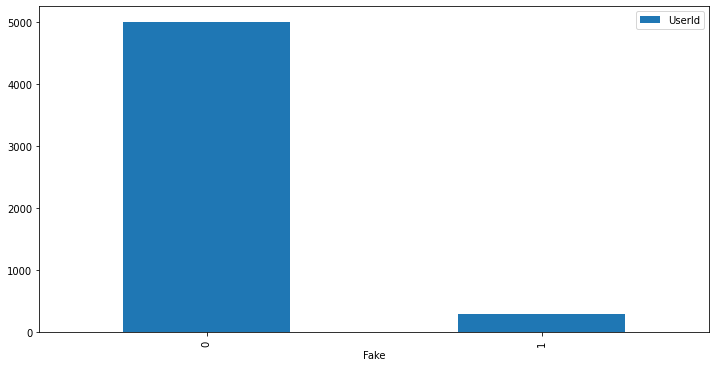

In [3]:
counts = users[["Fake", "UserId"]].drop_duplicates(subset=["UserId"]).groupby("Fake").count()

counts.plot(kind="bar", figsize=(12, 6))

In [4]:
(counts / len(users.drop_duplicates(subset=["UserId"]))) * 100

,UserId
Fake,
0,94.339623
1,5.660377


The dataset is extremely unbalanced: only 5.66 percent of users are fake.

Let's look at the distributions of events and categories for fake vs real users

In [5]:
counts = users[["Fake", "Event", "UserId"]].groupby(["Fake", "Event"]).count()
percentages = counts / counts.groupby(level=0).sum()

<AxesSubplot:xlabel='Fake'>

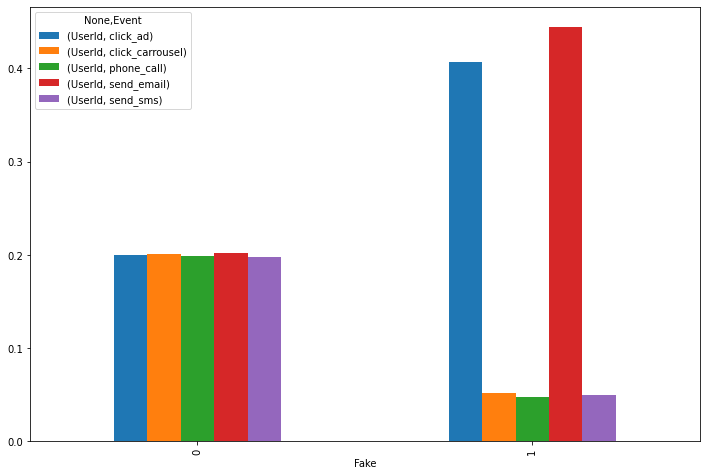

In [6]:
percentages.unstack().plot.bar(figsize=(12, 8))

It's clear that the distribution of events is very different for fake users compared to regular users. Fake users are much more likely to `click_ad` and `send_email`

Let's check whether there's a pattern in the distributions of categories

In [7]:
counts = users[["Fake", "Category", "UserId"]].groupby(["Fake", "Category"]).count()
percentages = counts / counts.groupby(level=0).sum()

<AxesSubplot:xlabel='Fake'>

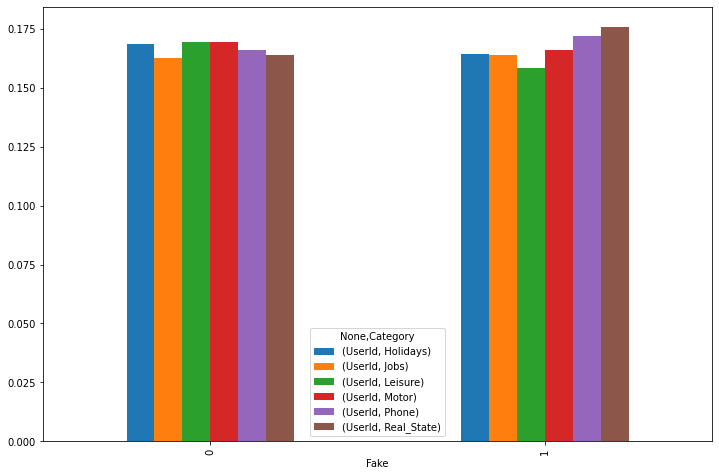

In [8]:
percentages.unstack().plot.bar(figsize=(12, 8))

There doesn't seem to be a significant difference here. Fake users seem to look at the same categories as regular users: all categories with roughly equal probability.

Next, let's see if we can find a way to classify users based on their behaviour. The purpose is to classify users as opposed to classifying events, so we'll need to transform the dataset a little bit. But first, let's check that indeed every user always has the same value for the `Fake` column

In [9]:
any(users.groupby("UserId").Fake.nunique() > 1)

False

Let's split the dataset into training, testing, and validation datasets. We'll make the split stratified to ensure that we have a similar distribution of fake and real users in different splits.

Create a ground truth table with only `UserId` and `Fake`

In [10]:
gt = users[["UserId", "Fake"]].drop_duplicates()
gt = gt.set_index("UserId")
gt

,Fake
UserId,
F7A7BF3761,0
BA8F7A71E6,0
21C64F22FC,0
F9E0306603,0
1B2143BACC,0
...,...
868D287036,0
A3A0EA61C2,0
4DF18F2FBD,0


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

# set random seed to make the experiments reproducible
np.random.seed(112)

# 80% training, 10% validation, and 10% testing
train, rest = train_test_split(gt, test_size=0.2, stratify=gt["Fake"])
valid, test = train_test_split(rest, test_size=0.5, stratify=rest["Fake"])

In [12]:
train.reset_index().groupby("Fake").count()

,UserId
Fake,
0,4000
1,240


In [13]:
valid.reset_index().groupby("Fake").count()

,UserId
Fake,
0,500
1,30


In [14]:
test.reset_index().groupby("Fake").count()

,UserId
Fake,
0,500
1,30


Simple input features: the distribution of events a user generates

In [15]:
counts = users[["UserId", "Event", "Fake"]].groupby(["UserId", "Event"]).count()
percentages = counts / counts.groupby(level=0).sum()

In [16]:
percentages = percentages.unstack()
percentages.columns = percentages.columns.droplevel()
percentages.columns.name = ""
percentages

,click_ad,click_carrousel,phone_call,send_email,send_sms
UserId,,,,,
00079D439D,0.263158,0.157895,0.210526,0.210526,0.157895
0007A4D4AE,0.250000,0.350000,0.200000,0.150000,0.050000
000AFE2623,0.142857,0.190476,0.142857,0.190476,0.333333
001A5362BC,0.187500,0.187500,0.187500,0.312500,0.125000
0025995AF5,0.190476,0.333333,0.142857,0.142857,0.190476
...,...,...,...,...,...
FFB0AC6E49,0.277778,0.055556,0.166667,0.222222,0.277778
FFC56B0CDD,0.375000,0.041667,0.125000,0.416667,0.041667
FFD2B9DC06,0.150000,0.300000,0.250000,0.250000,0.050000


In [17]:
train_features = pd.merge(percentages, train, left_index=True, right_index=True, how="right")
valid_features = pd.merge(percentages, valid, left_index=True, right_index=True, how="right")
test_features = pd.merge(percentages, test, left_index=True, right_index=True, how="right")

In [18]:
train_features

,click_ad,click_carrousel,phone_call,send_email,send_sms,Fake
UserId,,,,,,
1F7EF1F15B,0.300000,0.200000,0.150000,0.150000,0.200000,0
468636CEA7,0.157895,0.157895,0.210526,0.368421,0.105263,0
C39FD3268D,NaN,0.105263,0.210526,0.526316,0.157895,0
1E85C352A1,0.428571,0.020408,0.040816,0.448980,0.061224,1
8CC3FE415F,0.222222,0.166667,0.166667,0.333333,0.111111,0
...,...,...,...,...,...,...
31798C18F0,0.066667,0.266667,0.200000,0.333333,0.133333,0
1DBC37DBFA,0.190476,0.047619,0.190476,0.285714,0.285714,0
3BA63AD67D,0.176471,0.294118,0.058824,0.176471,0.294118,0


Next let's do binary classification with XGBoost. XGBoost can handle missing data, so we don't have to worry about it.

In [19]:
from xgboost import XGBClassifier

X_train, Y_train = train_features.values[:, :-1], train_features.values[:, -1]
model = XGBClassifier(eval_metric="logloss", use_label_encoder=False)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [20]:
X_valid, Y_valid = valid_features.values[:, :-1], valid_features.values[:, -1]
P_valid = model.predict(X_valid)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(Y_valid, P_valid, digits=4))

              precision    recall  f1-score   support

         0.0     0.9960    0.9980    0.9970       500
         1.0     0.9655    0.9333    0.9492        30

    accuracy                         0.9943       530
   macro avg     0.9808    0.9657    0.9731       530
weighted avg     0.9943    0.9943    0.9943       530



That was easy! We seem to have a pretty good accuracy right off the bat with this very simple approach. Let's look at the incorrect predictions to see if we can do anything about them.

In [22]:
valid_features["PredictedFake"] = P_valid.astype(int)
valid_features[valid_features["Fake"] != valid_features["PredictedFake"]]

,click_ad,click_carrousel,phone_call,send_email,send_sms,Fake,PredictedFake
UserId,,,,,,,
6C67CDA238,0.315789,0.052632,0.105263,0.421053,0.105263,0,1
A658DFA0D1,0.529412,0.147059,0.029412,0.176471,0.117647,1,0
AEA8DCAD2C,0.363636,0.136364,0.136364,0.318182,0.045455,1,0


Nothing very surprising here. A real user who happened to behave similarly to a fake user (high `send_email` and high `click_ad`) was classified as fake, and a couple of fake users misclassified as real.

I would imagine that the latter kind of error should be more tolerable as the goal is to reduce the number of fake users while not bothering real users by wrongly accusing them of being fake.

So far we've only used as features the distribution of events generated by users, but not the absolute number of generated events. Let's look at that, perhaps fake users generate many more events than real users? That would be a useful feature.

In [23]:
users[["UserId", "Event", "Fake"]].groupby(["Fake", "UserId"]).count().groupby(level=0).mean()

,Event
Fake,
0,18.0228
1,34.5300


Indeed, it seems that the average number of events generated by a fake user is almost 2x higher than the average number of events generated by a real user.

Let's see what happens if we use the total number of events generated by a user as an input feature.

In [24]:
event_counts = users[["UserId", "Event"]].groupby("UserId").count()
event_counts

,Event
UserId,
00079D439D,19
0007A4D4AE,20
000AFE2623,21
001A5362BC,16
0025995AF5,21
...,...
FFB0AC6E49,18
FFC56B0CDD,24
FFD2B9DC06,20


In [25]:
train_features = pd.merge(
    event_counts,
    pd.merge(percentages, train, left_index=True, right_index=True, how="right"),
    how="right",
    left_index=True,
    right_index=True,
)
valid_features = pd.merge(
    event_counts,
    pd.merge(percentages, valid, left_index=True, right_index=True, how="right"),
    how="right",
    left_index=True,
    right_index=True,
)
test_features = pd.merge(
    event_counts,
    pd.merge(percentages, test, left_index=True, right_index=True, how="right"),
    how="right",
    left_index=True,
    right_index=True,
)

In [26]:
X_train, Y_train = train_features.values[:, :-1], train_features.values[:, -1]
model = XGBClassifier(eval_metric="logloss", use_label_encoder=False)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [59]:
train_features

,Event,click_ad,click_carrousel,phone_call,send_email,send_sms,Fake
UserId,,,,,,,
1F7EF1F15B,20,0.300000,0.200000,0.150000,0.150000,0.200000,0
468636CEA7,19,0.157895,0.157895,0.210526,0.368421,0.105263,0
C39FD3268D,19,NaN,0.105263,0.210526,0.526316,0.157895,0
1E85C352A1,49,0.428571,0.020408,0.040816,0.448980,0.061224,1
8CC3FE415F,18,0.222222,0.166667,0.166667,0.333333,0.111111,0
...,...,...,...,...,...,...,...
31798C18F0,15,0.066667,0.266667,0.200000,0.333333,0.133333,0
1DBC37DBFA,21,0.190476,0.047619,0.190476,0.285714,0.285714,0
3BA63AD67D,17,0.176471,0.294118,0.058824,0.176471,0.294118,0


In [27]:
X_valid, Y_valid = valid_features.values[:, :-1], valid_features.values[:, -1]
P_valid = model.predict(X_valid)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(Y_valid, P_valid, digits=4))

              precision    recall  f1-score   support

         0.0     0.9980    1.0000    0.9990       500
         1.0     1.0000    0.9667    0.9831        30

    accuracy                         0.9981       530
   macro avg     0.9990    0.9833    0.9910       530
weighted avg     0.9981    0.9981    0.9981       530



🔥🔥🔥

Our new feature improves performance indeed. We're now looking 99.1% macro average f1 score on the validation dataset. That's great!

Let's try to find the best confidence threshold. Can we get to 100% macro average f1 score?

In [48]:
best_threshold = 0.01
best_f1 = -1

for threshold in np.arange(0.01, 1, 0.01):
    dic = classification_report(Y_valid, model.predict_proba(X_valid)[:, 1] > threshold, output_dict=True)
    fake_f1 = dic['macro avg']["f1-score"]
    if fake_f1 >= best_f1:
        best_threshold = threshold
        best_f1 = fake_f1

In [49]:
best_threshold

0.11

Let's do a final evaluation of our model. Does the model we've trained on the features and confidence threshold we've chosen generalize to the test dataset?

In [50]:
X_test, Y_test = test_features.values[:, :-1], test_features.values[:, -1]
P_test = model.predict_proba(X_test)[:, 1] > best_threshold

In [51]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, P_test, digits=4))

              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000       500
         1.0     1.0000    1.0000    1.0000        30

    accuracy                         1.0000       530
   macro avg     1.0000    1.0000    1.0000       530
weighted avg     1.0000    1.0000    1.0000       530



Cool! 100% classification accuracy on the test set. I've never seen this in my career as a data scientist, but I guess this is a toy problem for testing people so the data is likely fake / automatically generated?

Did I accidentally leak test or validation data into training data?

In [52]:
any(test_features.index.isin(train_features.index))

False

In [53]:
any(valid_features.index.isin(train_features.index))

False

In [54]:
any(test_features.index.isin(valid_features.index))

False

Let's save the model to a file

In [57]:
import pickle

with open("../models/xgboost.pkl", "wb") as f:
    pickle.dump(model, f)

Total amount of time spent so far: 1h42 minutes